Logistic回归模型 (线性不可分)
====

用正则化的Logistic回归模型来预测一个制造工厂的微芯片是否通过质量保证（QA），在QA过程中，每个芯片都会经过各种测试来保证它可以正常运行。假设你是这个工厂的产品经理，你拥有一些芯片在两个不同测试下的测试结果，从这两个测试，你希望确定这些芯片是被接受还是拒绝，为了帮助你做这个决定，你有一些以前芯片的测试结果数据集，从中你可以建一个Logistic回归模型。


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mp

np.set_printoptions(suppress=True, precision=4, floatmode='fixed')
## 全局设置
plt.rcParams['figure.figsize']=(8, 8)
# plt.rcParams['font.sans-serif'] = ['SimHei']
# plt.rcParams['axes.unicode_minus'] = False


# 原始数据

In [3]:
data = pd.read_csv('ex2data2.txt', names = ['Test_1','Test_2','Accepted'])


In [4]:
data[:10]


,Test_1,Test_2,Accepted
0,0.051267,0.699560,1
1,-0.092742,0.684940,1
2,-0.213710,0.692250,1
3,-0.375000,0.502190,1
4,-0.513250,0.465640,1
5,-0.524770,0.209800,1
6,-0.398040,0.034357,1
7,-0.305880,-0.192250,1
8,0.016705,-0.404240,1
9,0.131910,-0.513890,1


In [5]:
data.shape


(118, 3)

Plotting data with + indicating (y = 1) examples and o indicatig (y = 0) examples.



<AxesSubplot:xlabel='Microchip Test 1', ylabel='Microchip Test 2'>

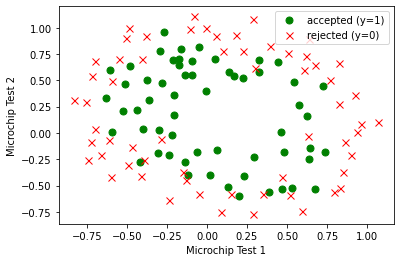

In [6]:
def plotData(data):
    _X = data.iloc[:, :-1]
    _y = data.iloc[:, -1:]
    pos = _X[_y['Accepted'] == 1]
    neg = _X[_y['Accepted'] == 0]

    print('Plotting data with + indicating (y = 1) examples and o indicatig (y = 0) examples.\n')
    fig, ax = plt.subplots()
    ax.plot(pos['Test_1'], pos['Test_2'], 'go', markersize=7, label='accepted (y=1)')
    ax.plot(neg['Test_1'], neg['Test_2'], 'rx', markersize=7, label='rejected (y=0)')
    ax.set_xlabel('Microchip Test 1')
    ax.set_ylabel('Microchip Test 2')
    ax.legend()

    return ax

plotData(data)


# 特征映射，创建高阶项特征

In [7]:
#3.特征映射
def mapFeature(x1, x2, power=6):
    data = {}
    for i in np.arange(1, power + 1):
        for j in np.arange(i + 1):
            data[f'F{i-j}{j}'] = np.power(x1, i - j) * np.power(x2, j)
    df = pd.DataFrame(data)
    df.insert(0, 'ones', 1) # 为bias(即theta 0) 插入x0 (恒为1)
    return df

x1 = data['Test_1']
x2 = data['Test_2']
data2 = mapFeature(x1, x2)
print(data2.head())

#4.构建数据集
X = data2.values
print(X.shape) # (118, 28)
y = data.iloc[:, -1:].values
print(y.shape) # (118, 1)


   ones       F10      F01       F20       F11       F02       F30       F21  \
0     1  0.051267  0.69956  0.002628  0.035864  0.489384  0.000135  0.001839   
1     1 -0.092742  0.68494  0.008601 -0.063523  0.469143 -0.000798  0.005891   
2     1 -0.213710  0.69225  0.045672 -0.147941  0.479210 -0.009761  0.031616   
3     1 -0.375000  0.50219  0.140625 -0.188321  0.252195 -0.052734  0.070620   
4     1 -0.513250  0.46564  0.263426 -0.238990  0.216821 -0.135203  0.122661   

        F12       F03  ...       F23       F14       F05           F60  \
0  0.025089  0.342354  ...  0.000900  0.012278  0.167542  1.815630e-08   
1 -0.043509  0.321335  ...  0.002764 -0.020412  0.150752  6.362953e-07   
2 -0.102412  0.331733  ...  0.015151 -0.049077  0.158970  9.526844e-05   
3 -0.094573  0.126650  ...  0.017810 -0.023851  0.031940  2.780914e-03   
4 -0.111283  0.100960  ...  0.026596 -0.024128  0.021890  1.827990e-02   

            F51       F42       F33       F24       F15       F06  
0  2.4

# 损失和梯度函数

In [8]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def computeCost(theta, X, y, lamda=1):
    '''
    COSTFUNCTIONREG Compute cost and gradient for logistic regression with regularization
       J = COSTFUNCTIONREG(theta, X, y, lambda) computes the cost of using
       theta as the parameter for regularized logistic regression and the
       gradient of the cost w.r.t. to the parameters.
    '''
    theta = theta.reshape((theta.shape[0], 1))
    m = len(y) # number of training examples
    h = sigmoid(X @ theta) # hypothesis function
    J = -1/m*np.sum(y * np.log(h) + (1-y)*np.log(1-h))
    regularized = lamda/(2*m) * np.sum( np.power(theta[1:], 2) )
    J += regularized

    grad = X.T @ (h-y) / m
    grad[1:] += (lamda/m)*theta[1:]
    return J, grad


In [9]:
initial_theta = np.zeros((X.shape[1], 1))  # 特征向量
print(X.shape, initial_theta.shape)


(118, 28) (28, 1)


In [10]:
# compute and display initial cost
print('\nTesting the cost function ...\n')
cost, grad = computeCost(initial_theta, X, y)
print(f'Cost at initial theta (zeros): {cost:.3f}')
print('Expected cost (approx): 0.693\n')
print('Gradient at initial theta (zeros) - first five values only:')
print(f'{grad[:5]} \n')
print('Expected gradients (approx) - first five values only:')
print(' 0.0085\n 0.0188\n 0.0001\n 0.0503\n 0.0115\n')



Testing the cost function ...

Cost at initial theta (zeros): 0.693
Expected cost (approx): 0.693

Gradient at initial theta (zeros) - first five values only:
[[0.0085]
 [0.0188]
 [0.0001]
 [0.0503]
 [0.0115]] 

Expected gradients (approx) - first five values only:
 0.0085
 0.0188
 0.0001
 0.0503
 0.0115



In [11]:
# Compute and display cost and gradient
# with all-ones theta and lambda = 10
test_theta = np.ones((X.shape[1], 1))
cost, grad = computeCost(test_theta, X, y, 10)
print(f'\nCost at test theta (with lambda = 10): {cost:.2f}')
print('Expected cost (approx): 3.16\n')
print('Gradient at test theta - first five values only:')
print(f'{grad[:5]} \n')
print('Expected gradients (approx) - first five values only:')
print(' 0.3460\n 0.1614\n 0.1948\n 0.2269\n 0.0922\n')



Cost at test theta (with lambda = 10): 3.16
Expected cost (approx): 3.16

Gradient at test theta - first five values only:
[[0.3460]
 [0.1614]
 [0.1948]
 [0.2269]
 [0.0922]] 

Expected gradients (approx) - first five values only:
 0.3460
 0.1614
 0.1948
 0.2269
 0.0922



# 使用梯度下降优化器

课程里推荐使用 Octave 的内置函数 `fminunc`. 

用python 实现的话, 我们可以使用`scipy.optimize` 库里的`fmin_tnc`函数

速度非常快 :-)

In [12]:
import scipy.optimize as opt

def train(X, y, theta, lamda=1):
    result = opt.fmin_tnc(func=computeCost, x0=initial_theta, args=(X, y, lamda))
    return result[0][:, np.newaxis] # 这里 fmin_tnc 返回的theta 是一维数组

final_theta = train(X, y, initial_theta, 1)
print('Theta found by fmin_tnc:')
print(final_theta)


Theta found by fmin_tnc:
[[ 1.2727]
 [ 0.6253]
 [ 1.1811]
 [-2.0199]
 [-0.9174]
 [-1.4317]
 [ 0.1239]
 [-0.3655]
 [-0.3573]
 [-0.1752]
 [-1.4582]
 [-0.0510]
 [-0.6156]
 [-0.2747]
 [-1.1927]
 [-0.2422]
 [-0.2060]
 [-0.0447]
 [-0.2778]
 [-0.2954]
 [-0.4565]
 [-1.0432]
 [ 0.0278]
 [-0.2924]
 [ 0.0156]
 [-0.3274]
 [-0.1439]
 [-0.9247]]


In [13]:
def predict(X, theta):
    prob = sigmoid(X @ theta)
    y_pred = np.int64(prob >= 0.5)
    return y_pred


# Compute accuracy on our training set
p = predict(X, final_theta)

print(f'Train Accuracy: {np.mean(p == y) * 100}')
print('Expected accuracy (with lambda = 1): 83.1 (approx)')


Train Accuracy: 83.05084745762711
Expected accuracy (with lambda = 1): 83.1 (approx)


# 决策边界

决策边界就是Xθ=0的时候

由 X * θ = 0 得
θ0 + θ1 * x1 + θ2 * x2 = 0

所以:
x2 = -θ0/θ2 - θ1/θ2 * x1


Plotting data with + indicating (y = 1) examples and o indicatig (y = 0) examples.



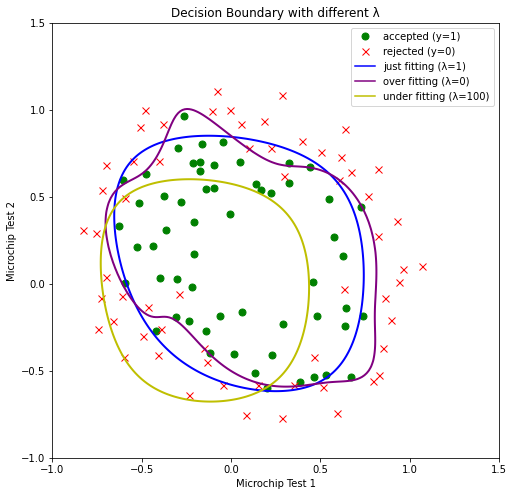

In [30]:
ax = plotData(data)   # 画原始数据

# Here is the grid range
a = np.linspace(-1, 1.5, 200)
U, V = np.meshgrid(a, a) # 模拟特征 x1, x2

z = mapFeature(U.flatten(), V.flatten()).values
Z1 = (z @ final_theta).reshape(U.shape)
cs = ax.contour(U, V, Z1, 0, colors='blue', linewidths=2) # lamda为1 恰到好处
cs.collections[0].set_label('just fitting (λ=1)')

theta_lamda_0 = train(X, y, initial_theta, 0)
theta_lamda_100 = train(X, y, initial_theta, 100)
Z0 = (z @ theta_lamda_0).reshape(U.shape)
Z100 = (z @ theta_lamda_100).reshape(U.shape)

cs = ax.contour(U, V, Z0, 0, colors='purple', linewidths=2)   # lamda为0 过拟合
cs.collections[0].set_label('over fitting (λ=0)')
cs = ax.contour(U, V, Z100, 0, colors='y', linewidths=2) # lamda太大 欠拟合
cs.collections[0].set_label('under fitting (λ=100)')
ax.set_title('Decision Boundary with different λ')

# if needs legend for contour collections, must use proxy as below
handles, labels = ax.get_legend_handles_labels()
# proxy = [plt.Rectangle((0,0), 1, 1, fc = pc.get_edgecolor()[0]) for pc in handles[2:]]

proxy = [mp.lines.Line2D((0,0), (0,1), c = pc.get_edgecolor()[0]) for pc in handles[2:]]
plt.legend(handles[:2] + proxy, labels)
plt.show()


# 自己实现梯度下降法算法

可以多尝试几次用不同的学习率 alpha 和 迭代次数, 以及lamda.

这里仅作为练习之用, 平时最好利用完善的三方库, 比如`scipy.optimize.fmin_tnc`

In [15]:
def gradientDescent(X, y, theta, alpha, num_iters, lamda):
    J_history = []
    for i in range(num_iters):
        J, grad = computeCost(theta, X, y, lamda)
        theta -= alpha * grad
        J_history.append(J)
    return theta, J_history


iterations = 100000
alpha = 0.001
initial_theta = np.zeros((X.shape[1], 1))
lamda = 0.5

print('\nRunning Gradient Descent ...\n')
got_theta, J_history = gradientDescent(X, y, initial_theta, alpha, iterations, lamda)



Running Gradient Descent ...



# 训练集准确率

In [16]:
# Compute accuracy on our training set
p = predict(X, got_theta)

print(f'Train Accuracy: {np.mean(p == y) * 100}')
print('Expected accuracy (with lambda = 1): 83.1 (approx)')


Train Accuracy: 83.05084745762711
Expected accuracy (with lambda = 1): 83.1 (approx)
